In [1]:
import pandas as pd
import math
import numpy as np
from sklearn import preprocessing, svm, model_selection
from sklearn.linear_model import LinearRegression
import datetime
import matplotlib.pyplot as plt
from matplotlib import style
import pickle

In [2]:
df = pd.read_csv('../Machine-Learning/Datasets/tesla-stock.csv')
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Volume         int64
Adj Close    float64
dtype: object

In [3]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst = False, yearfirst = False)
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Volume                int64
Adj Close           float64
dtype: object

In [4]:
df = df.set_index('Date')

# Labels and Features

### Features - it's the set of attributes which are actually input and on which our model will be trained.

### Labels - It's the set of attributes which are actually output, i.e values on which data will be tested and results will be predicted.

#### Adding new and more usefull features in the DataFrame - 

In [5]:
df['HL_PCT'] = (df['High'] - df['Low']) / df['Low'] * 100
df['PCT_Change'] = (df['Close'] - df['Open']) / df['Open'] * 100

In [6]:
#           X           X          price     X
df = df[['HL_PCT', 'PCT_Change', 'Close', 'Volume']]

In [7]:
df.head()

,HL_PCT,PCT_Change,Close,Volume
Date,,,,
2010-06-29,42.531349,25.736837,23.889999,18766300
2010-06-30,30.557946,-7.599848,23.830000,17187100
2010-07-01,27.873705,-12.160004,21.959999,8218800
2010-07-02,23.463395,-16.521735,19.200001,5139800
2010-07-06,26.342388,-19.449995,16.110001,6866900


forcast_count = math.ceil(0.01*len(df))
#### i.e. forecast_count represents 1% length of df or 17 days in this case
#### This was done so that we can actually decide that for how many values / days / rows in future the value has to be predicted.

In [8]:
forecast_col = 'Close'
forecast_count = math.ceil(0.1*len(df))
df.fillna(-99999, inplace=True)
print(forecast_count)

170


In [9]:
df.iloc[forecast_count:, 3]

Date
2011-03-02     663300
2011-03-03     640200
2011-03-04    1580100
2011-03-07    2033600
2011-03-08    1399900
               ...   
2017-03-13    3010700
2017-03-14    7575500
2017-03-15    4816600
2017-03-16    7100400
2017-03-17    6475900
Name: Volume, Length: 1522, dtype: int64

#### .shift(+/- value) - it shifts the column or DataFrame up & down respectively by the no of rows mentioned (values), empty places are filled with NaNs.
#### above iloc is used to demostrate the shift taking place in the DataFrame which you can see below.

In [10]:
df['label'] = df[forecast_col].shift(-forecast_count)

In [11]:
df

,HL_PCT,PCT_Change,Close,Volume,label
Date,,,,,
2010-06-29,42.531349,25.736837,23.889999,18766300,24.020000
2010-06-30,30.557946,-7.599848,23.830000,17187100,24.360001
2010-07-01,27.873705,-12.160004,21.959999,8218800,24.950001
2010-07-02,23.463395,-16.521735,19.200001,5139800,24.940001
2010-07-06,26.342388,-19.449995,16.110001,6866900,24.660000
...,...,...,...,...,...
2017-03-13,1.676418,0.551422,246.169998,3010700,NaN
2017-03-14,4.918296,4.831173,258.000000,7575500,NaN
2017-03-15,2.646791,-0.494165,255.729996,4816600,NaN


# Preparing the Data

#### For training & testing scikit-learn cannot directly work with pandas DataFrames instead, it's made fundamentally to work with NumPy Arrays. So we convert the Cleaned Data frames to Numpy Arrays.

#### Here, we use X to denote all the features and y for all the labels

In [12]:
X = np.array(df.drop(['label'], axis =1))

# print(len(X), len(y))
# print(X)

#### Scaling is the process of cleaning & bringing all the data in the range of 1 and -1. It helps in increasing the computation time. In mathematical words, all the data is NORMALIZED. This function returns a new Dataset.

In [13]:
X = preprocessing.scale(X)
print(len(X))
X

1692


array([[13.67536423,  9.03129813, -1.15117251,  3.3752191 ],
       [ 9.40618273, -2.66059874, -1.15180886,  3.00751021],
       [ 8.44910229, -4.25994396, -1.17164229,  0.919286  ],
       ...,
       [-0.54568987, -0.16848179,  1.30774703,  0.12710059],
       [-0.56864385, -0.04194895,  1.37477754,  0.6588721 ],
       [-0.92564847, -0.3272902 ,  1.36894431,  0.51346037]])

#### After the data is preprocessed, we divide the data in 2 parts  
#### 1. Data for Training & Testing - X
#### 2. Data for prediction    - X_lately
As decieded, we seperate the last 1% data from X and move it to X_lately for prediction

In [14]:
X_lately = X[-forecast_count:]
X = X[:-forecast_count]
df.dropna(inplace=True)
y = np.array(df['label'])
print(len(X), len(y))

1522 1522


# Testing & Training

#### cross_validation is outdated, now model_selection is used. Out of which we used "test_train_split" to split data into 2 parts
1. Training Data - on which model will be fitted / trained.
2. Tested Data - on which we'll find the output and calculate accuracy & score aka confidence.

#### test_size = 0.2 means that out of 100% of new X, we'll train on 80% data and test on 20%

In [15]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size =0.2)

## Classifier is the Algorithm used.
### Linear Regression

In [16]:
# clf = LinearRegression(n_jobs =-1)

## Training

####  .fit( X, y ) -  it's the training of the model.
#### The model learns trend for what values of different attributes in X_train, values in y_train exist.

In [17]:
# clf.fit(X_train, y_train)
# with open ('linearregression.pickle', 'wb') as f:
#     pickle.dump(clf, f)

pickle_in = open('linearregression.pickle', 'rb')
clf = pickle.load(pickle_in)

## Pickling
#### It's the process of training and then saving it to a file so that we don't need to train the classifier or the model again and again.

## Testing
#### .score( X, y ) - it's the testing of model on the given data and calculation of accuracy of our model.
#### Model after training, predicts the values of attributes in y_test after analysing the values of attributes in X_test.

In [18]:
accuracy = clf.score(X_test, y_test)
accuracy

0.7637597353986882

### Training & Testing Using Support Vector Regression from Support Vector Machines (SVM)

In [19]:
# for k in ['linear', 'poly', 'rbf', 'sigmoid']:
#     clf = svm.SVR(kernel=k)
#     clf.fit(X_train, y_train)
#     confidence = clf.score(X_test, y_test)
#     print(k, confidence)

# Predicting

#### .predict() - returns a list or number depending upon the input
#### Making a seperate column "Forecast" for predicted values and making all it's values NaN

In [20]:
forecast_price = clf.predict(X_lately)
forecast_price
df['forecast'] = np.NaN
df

,HL_PCT,PCT_Change,Close,Volume,label,forecast
Date,,,,,,
2010-06-29,42.531349,25.736837,23.889999,18766300,24.020000,NaN
2010-06-30,30.557946,-7.599848,23.830000,17187100,24.360001,NaN
2010-07-01,27.873705,-12.160004,21.959999,8218800,24.950001,NaN
2010-07-02,23.463395,-16.521735,19.200001,5139800,24.940001,NaN
2010-07-06,26.342388,-19.449995,16.110001,6866900,24.660000,NaN
...,...,...,...,...,...,...
2016-07-08,2.475524,-0.468321,216.779999,4074800,246.169998,NaN
2016-07-11,3.311924,2.191304,224.779999,5429800,258.000000,NaN
2016-07-12,1.917390,0.245421,224.649994,4571300,255.729996,NaN


In [21]:
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_price:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns) -1)] + [i]

#### In above code, we're adding more rows to the DataFrame, since our model won't predict anything other than Prices therefore we make all other NaNs and seperately add Forecast prices
#### Since, new dates do not exist in the df therefore we generate more from DateTime module

In [22]:
df.tail(30)

,HL_PCT,PCT_Change,Close,Volume,label,forecast
Date,,,,,,
2016-12-02 05:30:00,NaN,NaN,NaN,NaN,NaN,238.463120
2016-12-03 05:30:00,NaN,NaN,NaN,NaN,NaN,242.541744
2016-12-04 05:30:00,NaN,NaN,NaN,NaN,NaN,252.696757
2016-12-05 05:30:00,NaN,NaN,NaN,NaN,NaN,248.117750
2016-12-06 05:30:00,NaN,NaN,NaN,NaN,NaN,278.787237
2016-12-07 05:30:00,NaN,NaN,NaN,NaN,NaN,255.852195
2016-12-08 05:30:00,NaN,NaN,NaN,NaN,NaN,274.211920
2016-12-09 05:30:00,NaN,NaN,NaN,NaN,NaN,279.253642
2016-12-10 05:30:00,NaN,NaN,NaN,NaN,NaN,269.550980


# Plotting

In [23]:
style.use('ggplot')

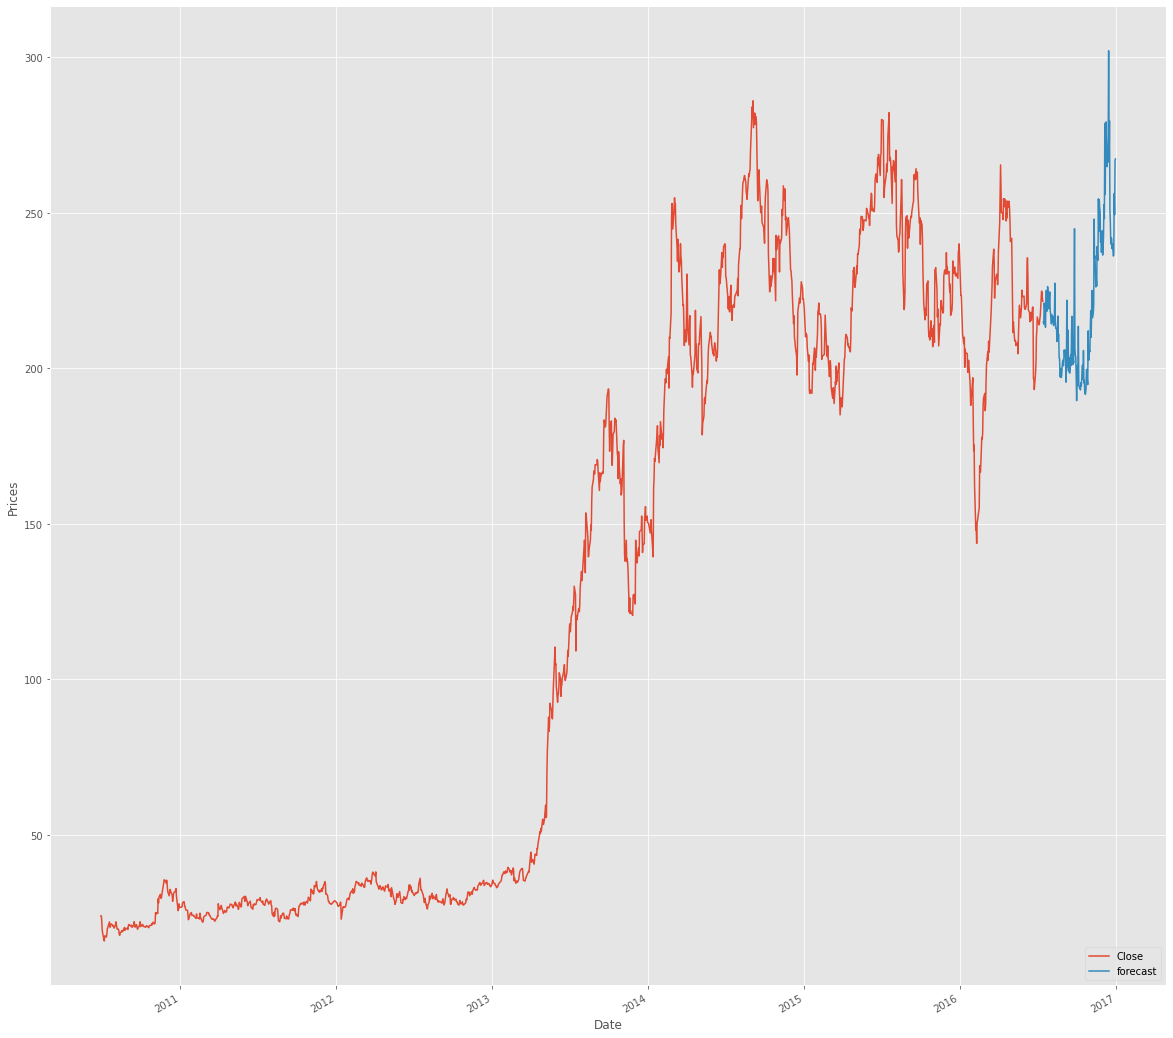

In [25]:
df['Close'].plot()
df['forecast'].plot()
plt.legend(loc = 4)
plt.xlabel('Date')
plt.ylabel('Prices')
plt.rcParams["figure.figsize"] = (20, 20)
plt.show()